In [39]:
import io
import sys
import numpy as np
import matplotlib.pyplot as plt
import time

trainImages = io.open('train-images.idx3-ubyte', 'rb')
trainLabels = io.open('train-labels.idx1-ubyte', 'rb')

In [40]:
magic = int.from_bytes(trainImages.read(4), byteorder='big')
if magic != 2051:
    sys.exit('Wrong magic number for train-images.idx3-ubyte')
    
magic = int.from_bytes(trainLabels.read(4), byteorder='big')
if magic != 2049:
    sys.exit('Wrong magic number for train-labels.idx3-ubyte')

imageNum = int.from_bytes(trainImages.read(4), byteorder='big')
labelNum = int.from_bytes(trainLabels.read(4), byteorder='big')

num = min(imageNum, labelNum)

# dimensions of each image
rowNum = int.from_bytes(trainImages.read(4), byteorder='big')
colNum = int.from_bytes(trainImages.read(4), byteorder='big')

images = np.zeros(num*colNum*rowNum).reshape(num, colNum*rowNum)
for i in range(num):
    for j in range(colNum*rowNum):
        images[i, j] = int.from_bytes(trainImages.read(1), byteorder='big', signed=False)

labels = np.zeros(num)
for i in range(num):
    labels[i] = int.from_bytes(trainLabels.read(1), byteorder='big', signed=False)

trainImages.close()
trainLabels.close()

# display the image specified by index

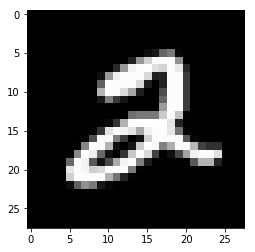

2.0


In [48]:
index = 5
sample = images[index].reshape(rowNum, colNum)
plt.imshow(sample, cmap='gray')
plt.show()
print(labels[index])

# SVD decomposition result

In [51]:
U, S, VT = np.linalg.svd(images, full_matrices=False)

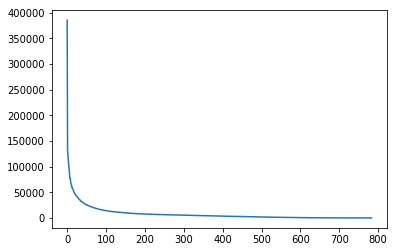

In [52]:
plt.plot(S)

# Using $w=(A^TA+\lambda I)^{-1}A^Td$ directly

In [80]:
start = time.time()
w = np.linalg.inv(images.transpose()@images+0.1*np.identity(rowNum*colNum))@images.transpose()@labels
end = time.time()
print('Total computation time by using inversion of matrice directly: ', (end - start))

Total computation time by using inversion of matrice directly:  2.145399808883667


# Display the distribution of weights

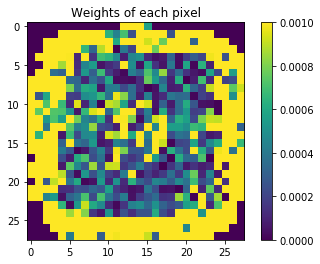

In [85]:
plt.imshow(np.absolute(w.reshape(rowNum, colNum)), vmax=0.001)
plt.colorbar()
plt.title('Weights of each pixel')
plt.show()

# show the intensity distribution of pixels

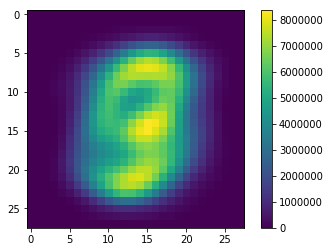

In [82]:
merge = np.zeros(rowNum*colNum)
for i in range(60000):
    merge = merge + images[i]

plt.imshow(merge.reshape(rowNum, colNum))
plt.colorbar()
plt.title('')
plt.show()